In [21]:
import pandas as pd
import numpy as np
import json
import gzip
import seaborn as sns
from datetime import datetime
from pandas.io.json import json_normalize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.externals import joblib
%matplotlib inline

In [2]:
def open_json(data_file):    
    with open(data_file, 'r') as f:
        json_records = []
        for line in f:
            record = json.loads(line)
            json_records.append(record)
    return json_records

def gender_to_bin(g):
    if g == 'M':
        return 1
    else:
        return 0

def bin_to_gender(g):
    if g == 1:
        return 'M'
    else:
        return 'F'

def to_weekday(timestamp):
    try:
        weekday = datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S").weekday()
    except ValueError:
        weekday = datetime.strptime(timestamp, "%Y-%m-%d").weekday()
    except TypeError:
        weekday = 1
    return weekday

## Create 5 DataFrames: catalog, purchase, pageview, target_purchase, target_pageview

In [5]:
%%time
catalog = pd.read_csv('data/catalog', usecols=['pid', 'current_price', 'category', 'sub_category', 'sub_sub_category'])
for i,val in enumerate(catalog.current_price.values):
    if np.isnan(val):
        catalog.current_price.values[i] = 0

purchase_data = open_json('data/sub_data/purchase')           
purchase = json_normalize(purchase_data, 'products', ['date','gender','uid'])

pageview_data = open_json('data/sub_data/products')   
pageview = pd.DataFrame(pageview_data, columns=['productId', 'timestamp', 'gender', 'uid'])
pageview.columns = ['pid', 'date', 'gender', 'uid']


purchase_data = open_json('data/sub_target/purchase')           
target_purchase = json_normalize(purchase_data, 'products', ['date','uid'])

pageview_data = open_json('data/sub_target/purchase')   
target_pageview = pd.DataFrame(pageview_data, columns=['productId', 'timestamp', 'uid'])
target_pageview.columns = ['pid', 'date', 'uid']

CPU times: user 7.85 s, sys: 528 ms, total: 8.38 s
Wall time: 8.45 s


## Transform gender and date into numbers

In [6]:
%%time
purchase.gender = list(map(gender_to_bin, purchase.gender.values))
purchase.date = list(map(to_weekday, purchase.date.values))

pageview.gender = list(map(gender_to_bin, pageview.gender.values))
pageview.date = list(map(to_weekday, pageview.date.values))


target_purchase.date = list(map(to_weekday, target_purchase.date.values))
target_pageview.date = list(map(to_weekday, target_pageview.date.values))

CPU times: user 18.1 s, sys: 16 ms, total: 18.1 s
Wall time: 18.2 s


## Set dummies vars for categorical features

In [7]:
%%time
categorical = ['category', 'sub_category', 'sub_sub_category', 'date']

purchase = purchase.join(catalog.set_index('pid'), on='pid')
purchase = pd.get_dummies(purchase, columns=categorical).iloc[:,1:]

pageview = pageview.join(catalog.set_index('pid'), on='pid')
pageview = pd.get_dummies(pageview, columns=categorical).iloc[:,1:]

target_purchase = target_purchase.join(catalog.set_index('pid'), on='pid')
target_purchase = pd.get_dummies(target_purchase, columns=categorical).iloc[:,1:]

target_pageview = target_pageview.join(catalog.set_index('pid'), on='pid')
target_pageview = pd.get_dummies(target_pageview, columns=categorical).iloc[:,1:]

CPU times: user 1.19 s, sys: 260 ms, total: 1.45 s
Wall time: 1.64 s


## Merge users with same uid (sum entries) and join DFs

In [8]:
len(target_purchase.uid.values)

12687

In [9]:
%%time
#quantity = purchase.pop('quantity')
purchase = purchase.groupby(['uid','gender'], as_index=False).sum()
pageview = pageview.groupby(['uid','gender'], as_index=False).sum()
data = purchase.join(pageview.set_index(['uid','gender']), on=['uid','gender'], rsuffix='_v')


target_purchase = target_purchase.groupby(['uid'], as_index=False).sum()
target_pageview = target_pageview.groupby(['uid'], as_index=False).sum()
target_data = target_purchase.join(target_pageview.set_index('uid'), on='uid', rsuffix='_v')

CPU times: user 1.53 s, sys: 760 ms, total: 2.29 s
Wall time: 2.4 s


In [10]:
data = data.fillna(value=0)
target_data = target_data.fillna(value=0)

In [11]:
features = data.columns[2:]
target = data.columns[1]
features2 = target_data.columns[1:]
features = list(set(features)&set(features2))

In [94]:
X = data[features]
Y = data[target]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

In [78]:
%%time
forest = RandomForestClassifier(n_estimators=100)
forest.fit(x_train, y_train)
y_pred = forest.predict(x_test)
score1 = metrics.accuracy_score(y_test, y_pred)
score2 = metrics.f1_score(y_test, y_pred, average='binary')
score3 = metrics.roc_auc_score(y_test, y_pred)
#joblib.dump(forest, '83.pkl')

CPU times: user 2.32 s, sys: 40 ms, total: 2.36 s
Wall time: 2.33 s


In [79]:
print score1, score2, score3

0.768612521151 0.803661162958 0.759030397355


In [95]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100,learning_rate=1.0,max_depth=1,random_state=0)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
score1 = metrics.accuracy_score(y_test, y_pred)
score2 = metrics.f1_score(y_test, y_pred, average='binary')
score3 = metrics.roc_auc_score(y_test, y_pred)
print score1, score2, score3

0.790226876091 0.82513820192 0.778325825826


## Output

In [96]:
X = target_data[features]
answer = clf.predict(X)
users = target_data.uid.values
ans = []
for i,u in enumerate(users):
    if answer[i]:
        g = 'M'
    else:
        g = 'F'
    obj = {'a':u, 'b':g}
    ans.append(obj)
    
import csv

with open('ans8.csv', 'wb') as f:
    w = csv.DictWriter(f, fieldnames=['a','b'])
    for obj in ans:
        w.writerow(obj)

In [19]:
data.head()

,uid,gender,quantity,current_price,category_11e623a37e87cf7995c466723ec99688d55cae8c,category_37b2661cc181c987f68770e43990152026920ba5,category_55599ee4735544f9319a030222f617a252d8ebf3,category_57ecb679698676e7a3ac843bef1e3f6844651a79,category_c1bd5fd999bd577743936898ada96496b547af3c,category_c37df0ae71b97699a478def3001a3516a905a51d,...,sub_sub_category_f86a9cce8e46d9cac88fd9306a6515fef89fe3fc_v,sub_sub_category_f9e79addaa1175027c52d95685b4664fa7430f0f_v,sub_sub_category_fecdd01f32c4b0a1e0d2b70cc3891dc52f964329_v,date_0_v,date_1_v,date_2_v,date_3_v,date_4_v,date_5_v,date_6_v
0,000130d3608d9f6cd7a951eb15bca73838a3a263,1,1.0,0.0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0002c71b578f597fc0e1e63f96fc3cf433ccbc15,0,1.0,99.9,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0002c9b12a68dba967fd9d71068c349d495a15ba,0,4.0,1579.6,0,0,0,0,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,000aa8ec02476d85a2416b5f66ef46a64bf1e319,1,1.0,309.9,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,000c678b3a022ab93a8603025dcba4ee23b55b15,0,1.0,399.9,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,23.0,1.0,0.0,0.0,0.0,0.0


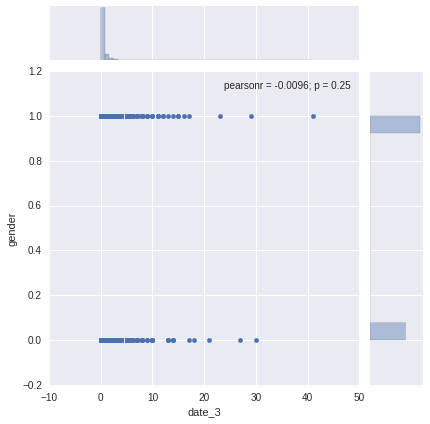

In [88]:
g = sns.jointplot(x="date_3", y="gender", data=data)